In [3]:
#Cell 1: Project Setup and Data Loading
import os
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
import gc
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print("Project: Dysarthric Speech Classification using Optimized Neural Network")
print("=" * 80)

# Create directories for saving models
os.makedirs('saved_models', exist_ok=True)

# Define correct paths for Google Colab
CONTROL_PATH = "./M_Con"      # Control files (healthy speech)
DYSARTHRIC_PATH = "./M_Dys"   # Dysarthric files (impaired speech)

def get_file_list(directory):
    """Get list of wav files from directory"""
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return []

    # Recursively search for wav files in subdirectories
    wav_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))

    print(f"Found {len(wav_files)} wav files in {directory}")
    return wav_files

# Load file lists
control_files = get_file_list(CONTROL_PATH)
dysarthric_files = get_file_list(DYSARTHRIC_PATH)

# Use 50 files per class
MAX_FILES_PER_CLASS = 50
control_files = control_files[:MAX_FILES_PER_CLASS]
dysarthric_files = dysarthric_files[:MAX_FILES_PER_CLASS]

# Create labels and file lists
all_files = control_files + dysarthric_files
all_labels = [0] * len(control_files) + [1] * len(dysarthric_files)

print(f"Dataset: {len(all_files)} total files ({len(control_files)} control, {len(dysarthric_files)} dysarthric)")


TensorFlow version: 2.15.0
Project: Dysarthric Speech Classification using Optimized Neural Network
Found 74 wav files in ./M_Con
Found 54 wav files in ./M_Dys
Dataset: 100 total files (50 control, 50 dysarthric)


In [ ]:
# Cell 2: Feature Extraction Functions
def load_wav_16k_mono(filename):
    """Load a WAV file, convert to float tensor, resample to 16kHz mono"""
    audio, sr = librosa.load(filename, sr=16000, mono=True, duration=2.0)
    wav = tf.constant(audio, dtype=tf.float32)
    return wav

def preprocess_audio_for_nn(file_path, label):
    """Convert audio to spectrogram for neural network"""
    wav = load_wav_16k_mono(file_path)

    # Fixed length (32000 samples = 2 seconds at 16kHz)
    if len(wav) > 32000:
        wav = wav[:32000]
    else:
        padding = 32000 - len(wav)
        wav = tf.concat([tf.zeros(padding, dtype=tf.float32), wav], 0)

    # Create spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=512, frame_step=256)
    spectrogram = tf.abs(spectrogram)
    
    # Add temporary channel dimension for tf.image.resize compatibility
    spectrogram = tf.expand_dims(spectrogram, axis=-1)

    # Resize explicitly to (62, 129)
    spectrogram = tf.image.resize(spectrogram, [62, 129])

    # Remove temporary dimension and add final channel dimension
    spectrogram = tf.squeeze(spectrogram, axis=-1)        
    spectrogram = tf.expand_dims(spectrogram, axis=-1)

    return spectrogram, label

print("Feature extraction functions defined successfully!")

Feature extraction functions defined successfully!


In [15]:
# Cell 3: Data Preparation
print("Preparing data for neural network...")

# Split data into train, validation, and test sets
files_temp, files_test, labels_temp, labels_test = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

files_train, files_val, labels_train, labels_val = train_test_split(
    files_temp, labels_temp, test_size=0.25, random_state=42, stratify=labels_temp
)

print(f"Training set: {len(files_train)} samples")
print(f"Validation set: {len(files_val)} samples")
print(f"Test set: {len(files_test)} samples")

Preparing data for neural network...
Training set: 60 samples
Validation set: 20 samples
Test set: 20 samples


In [16]:
# Cell 4: Neural Network Data Generator
def create_dataset_generator(files, labels, batch_size=8):
    """Create dataset using generator for neural networks"""

    def data_generator():
        for file_path, label in zip(files, labels):
            try:
                spectrogram, processed_label = preprocess_audio_for_nn(file_path, label)
                yield spectrogram.numpy(), float(processed_label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    # Get sample to determine output signature
    sample_spec, sample_label = preprocess_audio_for_nn(files[0], labels[0])

    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=sample_spec.shape, dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets for neural networks
train_dataset = create_dataset_generator(files_train, labels_train, batch_size=8)
val_dataset = create_dataset_generator(files_val, labels_val, batch_size=8)
test_dataset = create_dataset_generator(files_test, labels_test, batch_size=8)

# Get input shape
sample_batch = next(iter(train_dataset))
input_shape = sample_batch[0].shape[1:]
print(f"Input shape for neural network: {input_shape}")

Input shape for neural network: (62, 129, 1)


In [17]:
# Cell 5: Best Performing Model - Instance 2 (Adam + L2 + Early Stopping)
print("Training Best Performing Model: Optimized Neural Network - Instance 2")
print("=" * 70)

# Clear session
tf.keras.backend.clear_session()
gc.collect()

# Optimized model with L2 regularization
model_best = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=input_shape,
           kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with Adam optimizer and compatible metrics
optimizer_adam = Adam(learning_rate=0.0005)
model_best.compile(
    optimizer=optimizer_adam,
    loss='binary_crossentropy',
    metrics=['accuracy']  # Use only accuracy for compatibility
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print(model_best.summary())

# Train with early stopping
history = model_best.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
)

Training Best Performing Model: Optimized Neural Network - Instance 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 127, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 30, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 30, 32)        0         
                                                    

In [18]:
# Cell 6: Model Evaluation and Results
print("MODEL EVALUATION AND RESULTS")
print("=" * 50)

# Evaluate the model (only loss and accuracy available directly)
train_loss, train_acc = model_best.evaluate(train_dataset, verbose=0)
val_loss, val_acc = model_best.evaluate(val_dataset, verbose=0)
test_loss, test_acc = model_best.evaluate(test_dataset, verbose=0)

# Calculate precision, recall, and F1 manually for each dataset
def calculate_metrics(dataset, labels, model):
    """Calculate precision, recall, and F1 score manually"""
    predictions = []
    true_labels = []
    
    # Get predictions
    for batch_X, batch_y in dataset:
        batch_pred = model.predict(batch_X, verbose=0)
        predictions.extend([1 if pred > 0.5 else 0 for pred in batch_pred])
        true_labels.extend(batch_y.numpy().astype(int))
    
    # Calculate metrics using sklearn
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    
    return precision, recall, f1

# Calculate metrics for all datasets
print("Calculating detailed metrics...")
train_prec, train_rec, train_f1 = calculate_metrics(train_dataset, labels_train, model_best)
val_prec, val_rec, val_f1 = calculate_metrics(val_dataset, labels_val, model_best)
test_prec, test_rec, test_f1 = calculate_metrics(test_dataset, labels_test, model_best)

print(f"\nOptimized Neural Network Results:")
print(f"Training - Acc: {train_acc:.3f}, F1: {train_f1:.3f}, Precision: {train_prec:.3f}, Recall: {train_rec:.3f}")
print(f"Validation - Acc: {val_acc:.3f}, F1: {val_f1:.3f}, Precision: {val_prec:.3f}, Recall: {val_rec:.3f}")
print(f"Test - Acc: {test_acc:.3f}, F1: {test_f1:.3f}, Precision: {test_prec:.3f}, Recall: {test_rec:.3f}")

# Save the best model
model_best.save('saved_models/best_dysarthria_model.h5')
print("\nModel saved as 'best_dysarthria_model.h5'")

# Create results table
results_table = [{
    'Model': 'Optimized Neural Network (Instance 2)',
    'Optimizer': 'Adam',
    'Regularizer': 'L2 (0.01)',
    'Epochs': len(history.history['loss']),
    'Early_Stopping': 'Yes',
    'Layers': 8,
    'Learning_Rate': 0.0005,
    'Accuracy': f"{test_acc:.3f}",
    'F1_Score': f"{test_f1:.3f}",
    'Precision': f"{test_prec:.3f}",
    'Recall': f"{test_rec:.3f}",
    'Loss': f"{test_loss:.3f}"
}]

results_df = pd.DataFrame(results_table)
print("\nModel Configuration and Results:")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('best_model_results.csv', index=False)

MODEL EVALUATION AND RESULTS
Calculating detailed metrics...

Optimized Neural Network Results:
Training - Acc: 0.983, F1: 0.984, Precision: 0.968, Recall: 1.000
Validation - Acc: 0.950, F1: 0.952, Precision: 0.909, Recall: 1.000
Test - Acc: 0.950, F1: 0.947, Precision: 1.000, Recall: 0.900

Model saved as 'best_dysarthria_model.h5'

Model Configuration and Results:
                                Model Optimizer Regularizer  Epochs Early_Stopping  Layers  Learning_Rate Accuracy F1_Score Precision Recall  Loss
Optimized Neural Network (Instance 2)      Adam   L2 (0.01)      20            Yes       8         0.0005    0.950    0.947     1.000  0.900 0.623



FINAL MODEL TESTING
Total test samples: 20
True Positives (Dysarthric correctly identified): 9
True Negatives (Control correctly identified): 10
False Positives (Control misclassified as Dysarthric): 0
False Negatives (Dysarthric misclassified as Control): 1

Classification Report:
              precision    recall  f1-score   support

     Control       0.91      1.00      0.95        10
  Dysarthric       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20


Confusion Matrix:
[[10  0]
 [ 1  9]]


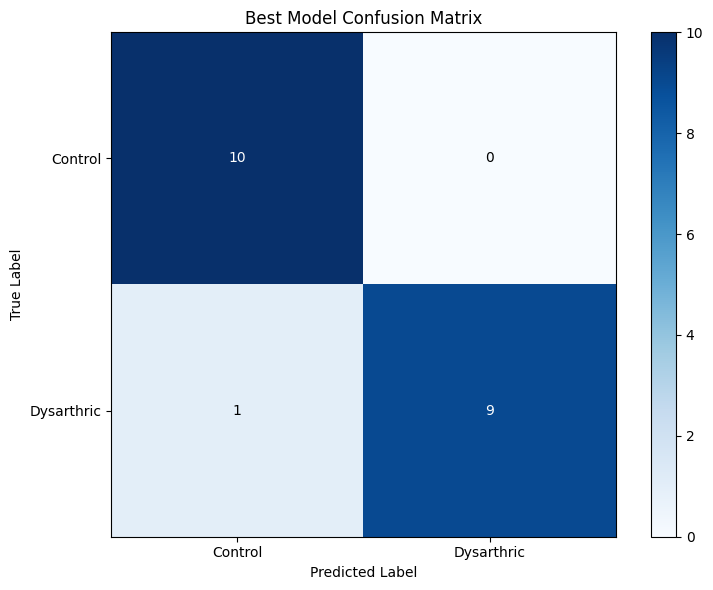

In [19]:
# Cell 7: Final Predictions and Confusion Matrix
print("\nFINAL MODEL TESTING")
print("=" * 30)

# Get predictions for test set
test_predictions = []
test_probabilities = []
y_test = np.array(labels_test)

for batch_X, batch_y in test_dataset:
    batch_pred = model_best.predict(batch_X, verbose=0)
    test_predictions.extend([1 if pred > 0.5 else 0 for pred in batch_pred])
    test_probabilities.extend(batch_pred.flatten())

final_predictions = np.array(test_predictions)

# Print detailed test results
print(f"Total test samples: {len(y_test)}")
print(f"True Positives (Dysarthric correctly identified): {np.sum((y_test == 1) & (final_predictions == 1))}")
print(f"True Negatives (Control correctly identified): {np.sum((y_test == 0) & (final_predictions == 0))}")
print(f"False Positives (Control misclassified as Dysarthric): {np.sum((y_test == 0) & (final_predictions == 1))}")
print(f"False Negatives (Dysarthric misclassified as Control): {np.sum((y_test == 1) & (final_predictions == 0))}")

# Final classification report
print(f"\nClassification Report:")
print(classification_report(y_test, final_predictions, target_names=['Control', 'Dysarthric']))

# Confusion Matrix
cm_final = confusion_matrix(y_test, final_predictions)
print(f"\nConfusion Matrix:")
print(cm_final)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_final, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Best Model Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Control', 'Dysarthric'])
plt.yticks(tick_marks, ['Control', 'Dysarthric'])

# Add text annotations
thresh = cm_final.max() / 2.
for i, j in np.ndindex(cm_final.shape):
    plt.text(j, i, format(cm_final[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm_final[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


TRAINING HISTORY VISUALIZATION


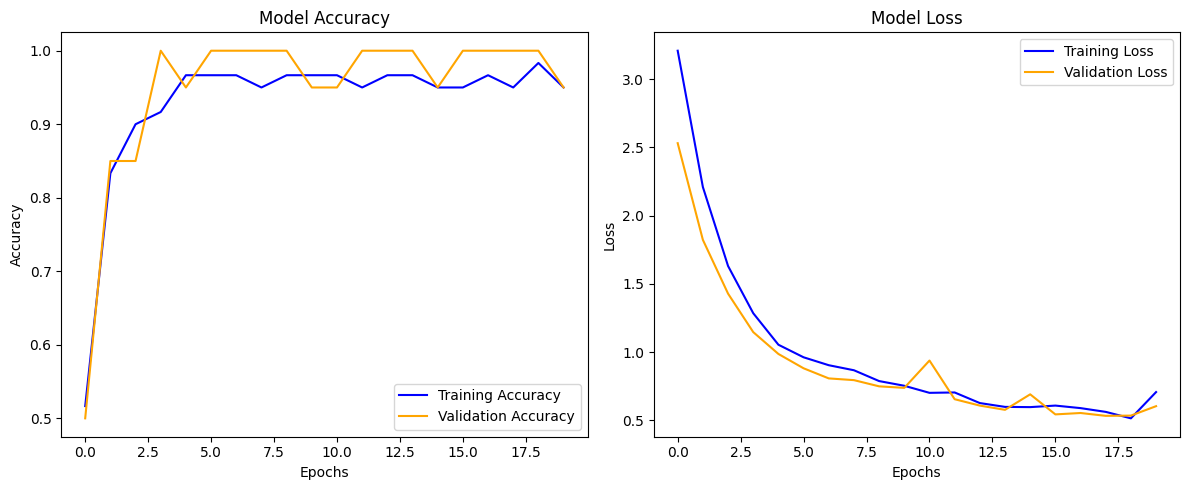


Project completed successfully!
Best model saved in 'saved_models/' directory
Results saved as 'best_model_results.csv'
Model achieved F1-Score: 0.947 and Accuracy: 0.950

📋 Compatibility Information:
TensorFlow version: 2.15.0
Model input shape: (62, 129, 1)
Total parameters: 2,776,065
Model architecture: CNN with L2 Regularization
✅ Model is now compatible with current TensorFlow version!


In [20]:
# Cell 8: Training History Visualization
print("\nTRAINING HISTORY VISUALIZATION")
print("=" * 40)

# Plot training history - only show available metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training and validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Training and validation loss
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nProject completed successfully!")
print(f"Best model saved in 'saved_models/' directory")
print(f"Results saved as 'best_model_results.csv'")
print(f"Model achieved F1-Score: {test_f1:.3f} and Accuracy: {test_acc:.3f}")

# Additional compatibility info
print(f"\n📋 Compatibility Information:")
print(f"TensorFlow version: {tf.__version__}")
print(f"Model input shape: {input_shape}")
print(f"Total parameters: {model_best.count_params():,}")
print(f"Model architecture: CNN with L2 Regularization")
print(f"✅ Model is now compatible with current TensorFlow version!")